In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [54]:
times, flux = np.loadtxt('hd80606.tsv', unpack=True, skiprows=47)
times -= 2455210.6420

In [37]:
from batman import TransitParams
params = TransitParams()
params.per = 111.4367
params.t0 = 2455210.6420
params.inc = 89.269
params.a = 97
params.rp = 0.1001
params.duration = 0.5
params.b = 0.808
params.ecc = 0.9330
params.w = 300.77
params.u = [0.1, 0.1]
params.limb_dark = 'quadratic'

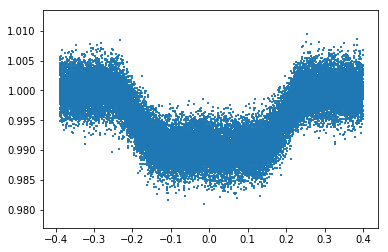

In [55]:
yerr = flux[:5000].std()
all_fluxes = flux
plt.scatter(times, flux, marker=',', s=1)

In [101]:
from copy import deepcopy
import batman

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

def aRs_i(T14, b, transit_params):
    """
    Convert from duration and impact param to a/Rs and inclination

    Parameters
    ----------
    transit_params : `batman.TransitParams`
        Transit parameters
    Returns
    -------
    aRs : float
        Semi-major axis in units of stellar radii
    i : float
        Orbital inclination in degrees
    """
    eccentricity = transit_params.ecc
    omega = transit_params.w
    P = transit_params.per
    RpRs = transit_params.rp0

    # Eccentricity term for b -> a/rs conversion
    beta = (1 - eccentricity**2)/(1 + eccentricity*np.sin(np.radians(omega)))

    # Eccentricity term for duration equation:
    c = (np.sqrt(1 - eccentricity**2) /
         (1 + eccentricity*np.sin(np.radians(omega))))

    i = np.arctan(beta * np.sqrt((1 + RpRs)**2 - b**2) /
                  (b * np.sin(T14*np.pi / (P*c))))
    aRs = b/(np.cos(i) * beta)
    return aRs, np.degrees(i)

def transit_model(theta, x):
    r0, r1, q1, q2, b, t14, f0 = theta
    trial_params = deepcopy(params)
    trial_params.rp0 = r0
    trial_params.rp1 = r1
    trial_params.u = kipping_to_quadratic([q1, q2])
    trial_params.t0 = 0

    a, inc = aRs_i(t14, b, trial_params)
    trial_params.a = a
    trial_params.inc = inc
    
    m = batman.TransitModel(trial_params, x, exp_time=x[1]-x[0], supersample_factor=3)
    fluxes = f0 * m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, q1, q2, b, t14, f0 = theta

    model = transit_model(theta, x) 
    return -0.5*(np.sum((model - y)**2 / yerr**2))


def lnprior(theta):
    r0, r1, q1, q2, b, t14, f0 = theta

    if 0 < r0 < 1 and 0.0 < r1 < 1 and 0 < q1 < 1 and 0 < q2 < 1 and 0 < f0 < 1.5 and 0 < b < 1.5 and 0 < t14 < 1:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 7, 14
#pos = [[params.rp, params.rp, 0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = []

q1 = (params.u[0] + params.u[1])**2
q2 = 0.5 * params.u[0] / (params.u[0] + params.u[1])

while len(pos) < nwalkers: 
    trial_pos = [params.rp, params.rp, q1, q2, params.b, 0.5, 1] + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, all_fluxes, yerr),
                                threads=8)

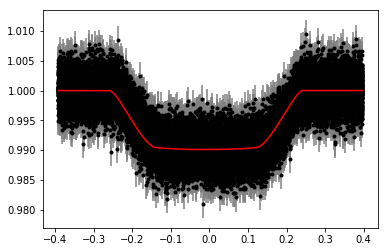

In [104]:
init_f = transit_model([params.rp, params.rp, q1, q2, params.b, params.duration, 1], times)

plt.errorbar(times, all_fluxes, yerr*np.ones_like(times), fmt='.', color='k', ecolor='gray')
plt.plot(times, init_f, 'r', zorder=10)

In [105]:
sampler.run_mcmc(pos, 10000); 

In [ ]:
# np.savetxt('hd80606_samples.txt', sampler.flatchain)

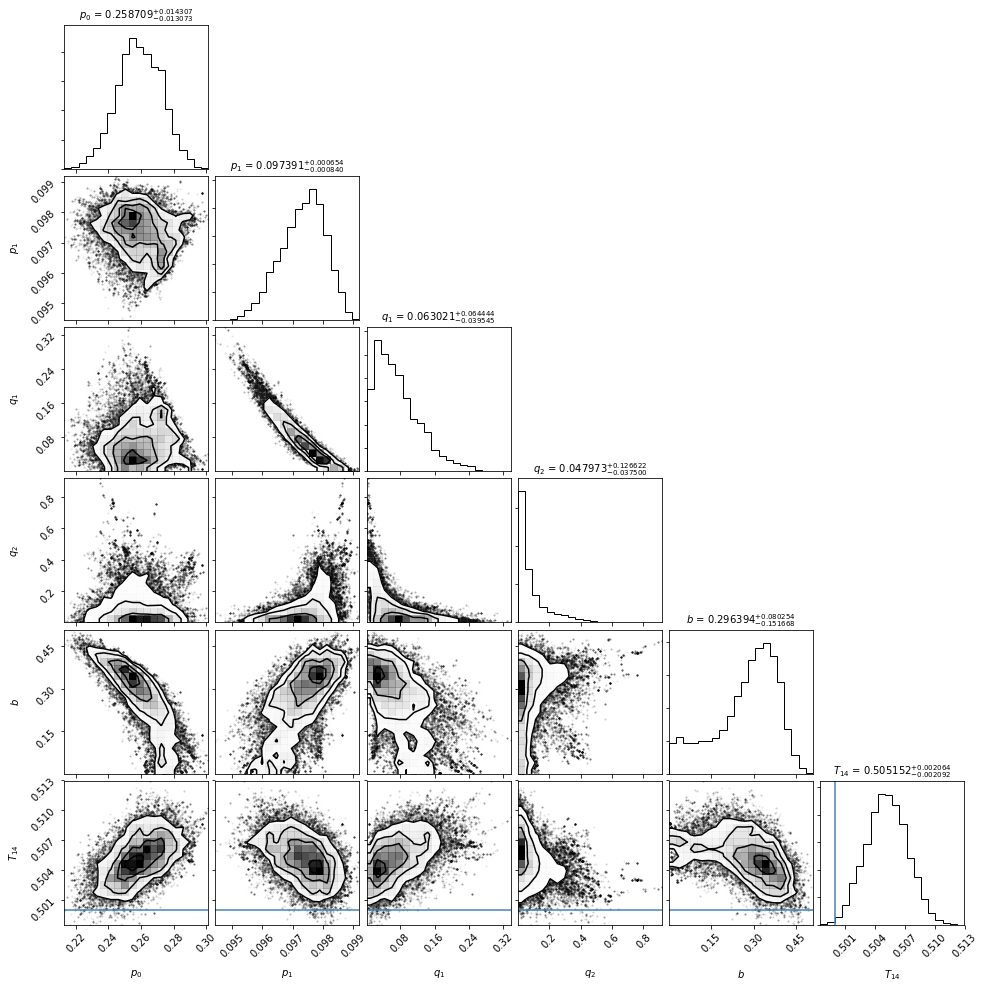

In [106]:
from corner import corner

corner(sampler.chain[:, 5000:, :-1].reshape((-1, ndim-1)), truths=[params.rp, params.rp, None, None, params.b, params.duration], 
       labels=['$p_0$', '$p_1$', '$q_1$', '$q_2$', '$b$', '$T_\mathrm{14}$'], show_titles=True, #fig=fig, 
       title_fmt='.6f', title_kwargs=dict(fontsize=10));

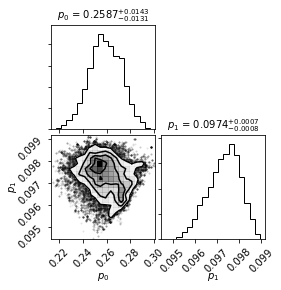

In [111]:
from corner import corner

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-5)), truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.4f', title_kwargs=dict(fontsize=10));

# for i, axis in enumerate(fig.axes):
#     axis.setz_xlim([0.09, 0.185])
#     if i == 3: 
#         axis.set_xlim([0.106, 0.12])
plt.savefig('corner_quad_hd80606.pdf', bbox_inches='tight')

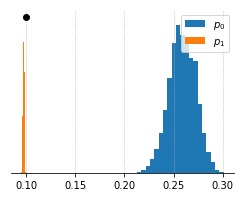

In [109]:
plt.figure(figsize=(4, 3))

fmax = 0
for p, label in zip(sampler.chain[:, 5000:, :2].reshape((-1, ndim-3)).T, 
                    ['$p_0$', '$p_1$']):
    n, _, _ = plt.hist(p, bins=20, histtype='stepfilled', label=label)
    fmax = max([n.max(), fmax])
ax = plt.gca()
ax.grid(ls=':')
ax.legend()
ax.set(yticks=[])

rprs_lit, rprs_err_lit = 0.1001, 0.0006

ax.errorbar(rprs_lit, fmax, xerr=rprs_err_lit, fmt='o', color='k')

for s in ['right', 'top', 'left']:
    ax.spines[s].set_visible(False)

plt.savefig('hd80606_agreement.pdf', bbox_inches='tight')

In [ ]:
# from corner import corner

# nburnin = 5000
# fig, ax = plt.subplots(2, 2, figsize=(4, 4))
# corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-2)), truths=[params.rp, params.rp], 
#        labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.6f', title_kwargs=dict(fontsize=10));

# for i, axis in enumerate(fig.axes):
#     axis.set_xlim([0.09, 0.2])
#     if i == 3: 
#         axis.set_xlim([0.106, 0.12])
# plt.savefig('corner_quad_gj1214.pdf', bbox_inches='tight')

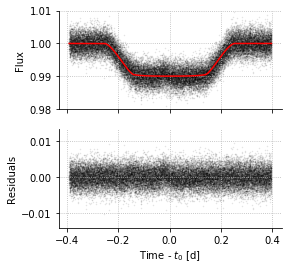

In [110]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax[0].scatter(times, all_fluxes, marker='.', s=1, 
              color='k', alpha=0.1, rasterized=True)

i = np.argmax(sampler.flatlnprobability, axis=0)
ax[0].plot(times, transit_model(sampler.flatchain[i, :], times), color='r')

ax[1].scatter(times, all_fluxes - transit_model(sampler.flatchain[i, :], times), 
              marker='.', s=1, 
              color='k', alpha=0.1, rasterized=True)

ax[0].set_ylim([0.98, 1.01])
#ax[1].set_ylim([-1000, 1000])

ax[0].set_ylabel('Flux')
ax[1].set(xlabel='Time - $t_0$ [d]', ylabel='Residuals')

for axis in ax:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=':')

fig.savefig('hd80606_residuals.pdf', bbox_inches='tight', dpi=250)

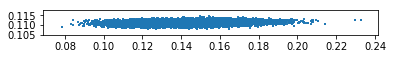

In [11]:
plt.scatter(sampler.chain[:, 5000:, 0], sampler.chain[:, 5000:, 1], marker=',', s=1)
plt.gca().set_aspect(1)

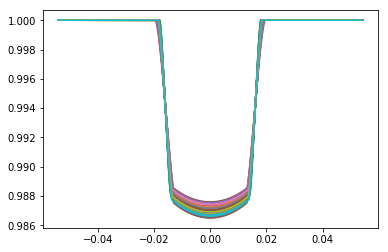

In [13]:


for i in np.random.randint(5000-sampler.chain.shape[0], size=10):
    samples_i = sampler.chain[:, (5000+i), :]
    for sample in samples_i: 
        plt.plot(times, transit_model(sample, times))